In [1]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data set
df = pickle.load(open('df.pkl','rb'))
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date,,,,,,
2013-01-01,0,2,1905,249.00,1.00,30
2013-01-01,0,14,1905,249.00,1.00,30
2013-01-01,0,46,1830,599.00,3.00,30
2013-01-01,0,19,22088,79.00,2.00,83
2013-01-01,0,37,22088,79.00,4.00,83


In [3]:
# Transform data into total sale per month of each store-item pair and their average price
aggregation = {'item_price':'mean',
               'item_cnt_day':'sum'}

train_model = df.groupby(['date_block_num','shop_id','item_id','item_category_id']).agg(aggregation)
train_model = train_model.reset_index()
train_model.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day
0,0,2,1905,30,249.00,3.00
1,0,2,1916,30,249.00,3.00
2,0,2,2308,30,799.00,3.00
3,0,2,2416,30,449.00,1.00
4,0,2,2808,30,998.98,17.00


In [4]:
# Sort dataframe
train_model.sort_values(['item_id','shop_id','date_block_num']).head()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day
7560,10,2,1495,30,632.33,8.00
8733,11,2,1495,30,599.00,20.00
9977,12,2,1495,30,599.00,9.00
12426,14,2,1495,30,599.00,2.00
13728,15,2,1495,30,599.00,1.00


In [5]:
# Pivot the table into item sales and item price columns by month
df_pivot = pd.pivot_table(data=pd.DataFrame(train_model),index=['shop_id','item_id','item_category_id'], 
                           columns=['date_block_num'], values=['item_cnt_day','item_price'])
df_pivot = df_pivot.reset_index()

print(df_pivot.head())
print(len(df_pivot))

               shop_id item_id item_category_id item_cnt_day                 \
date_block_num                                             0    1    2    3   
0                    2    1495               30          nan  nan  nan  nan   
1                    2    1830               30          nan  nan 3.00 2.00   
2                    2    1855               30          nan  nan  nan  nan   
3                    2    1905               30         3.00  nan  nan 2.00   
4                    2    1916               30         3.00 2.00 2.00 2.00   

                              ... item_price                              \
date_block_num    4    5    6 ...         24     25     26     27     28   
0               nan  nan  nan ...        nan    nan    nan 499.00    nan   
1              3.00 2.00 2.00 ...        nan    nan    nan    nan    nan   
2               nan  nan  nan ...     799.00 627.83 399.50    nan    nan   
3               nan 3.00 2.00 ...     249.00 249.00 249.00 249.00 

In [6]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 71 columns):
(shop_id, )             1919 non-null int64
(item_id, )             1919 non-null int64
(item_category_id, )    1919 non-null int64
(item_cnt_day, 0)       459 non-null float64
(item_cnt_day, 1)       534 non-null float64
(item_cnt_day, 2)       659 non-null float64
(item_cnt_day, 3)       654 non-null float64
(item_cnt_day, 4)       711 non-null float64
(item_cnt_day, 5)       772 non-null float64
(item_cnt_day, 6)       802 non-null float64
(item_cnt_day, 7)       866 non-null float64
(item_cnt_day, 8)       1045 non-null float64
(item_cnt_day, 9)       1058 non-null float64
(item_cnt_day, 10)      1173 non-null float64
(item_cnt_day, 11)      1244 non-null float64
(item_cnt_day, 12)      1219 non-null float64
(item_cnt_day, 13)      1230 non-null float64
(item_cnt_day, 14)      1302 non-null float64
(item_cnt_day, 15)      1257 non-null float64
(item_cnt_day, 16)      1291 non-

In [7]:
# Extract index as a single dataframe
df_index = df_pivot[['shop_id','item_id','item_category_id']]

print(df_index.head())
df_index.info()

               shop_id item_id item_category_id
date_block_num                                 
0                    2    1495               30
1                    2    1830               30
2                    2    1855               30
3                    2    1905               30
4                    2    1916               30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 3 columns):
(shop_id, )             1919 non-null int64
(item_id, )             1919 non-null int64
(item_category_id, )    1919 non-null int64
dtypes: int64(3)
memory usage: 45.1 KB


In [8]:
# Extract sales columns and fill in nan with zero
df_sales = df_pivot.loc[:,['item_cnt_day']]
df_sales = df_sales.fillna(0)
df_index.columns = df_index.columns.get_level_values(0)
df_sales.columns = df_sales.columns.get_level_values(1)
df_sales = pd.merge(df_index, df_sales, on=df_index.index).drop('key_0', axis=1)
df_sales.head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,2,1495,30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00
1,2,1830,30,0.00,0.00,3.00,2.00,3.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,1855,30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,2,1905,30,3.00,0.00,0.00,2.00,0.00,3.00,2.00,...,5.00,4.00,2.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00
4,2,1916,30,3.00,2.00,2.00,2.00,2.00,0.00,2.00,...,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00


Unlike sales record where we can simply fill in nan with 0 to replace months of no sales. The price dataframe has nan before and after the months that sales have been records. Therefore, we can use back fill on months before the sales are made and forward fill on the months after. Doing so we can assume that price adjustments are only made on the months that sales are made.

In [9]:
df_price = df_pivot.loc[:,['item_price']]
df_index.columns = df_index.columns.get_level_values(0)
df_price.columns = df_price.columns.get_level_values(1)
df_price = pd.merge(df_index, df_price, on=df_index.index).drop('key_0', axis=1)
df_price.head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,2,1495,30,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,499.00,nan,nan,nan,499.00,nan,nan
1,2,1830,30,nan,nan,449.25,599.00,599.00,599.00,399.56,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2,1855,30,nan,nan,nan,nan,nan,nan,nan,...,799.00,627.83,399.50,nan,nan,nan,nan,nan,399.00,nan
3,2,1905,30,249.00,nan,nan,249.00,nan,249.00,249.00,...,249.00,249.00,249.00,249.00,249.00,249.00,249.00,nan,nan,nan
4,2,1916,30,249.00,249.00,249.00,249.00,224.00,nan,249.00,...,nan,249.00,249.00,249.00,249.00,nan,nan,nan,nan,nan


In [10]:
dT_price = df_price.transpose()
df_price = dT_price.fillna(method='bfill').fillna(method='ffill')
df_price = df_price.transpose()
df_price.head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,2.00,1495.00,30.00,632.33,632.33,632.33,632.33,632.33,632.33,632.33,...,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.00
1,2.00,1830.00,30.00,449.25,449.25,449.25,599.00,599.00,599.00,399.56,...,599.00,599.00,599.00,599.00,599.00,599.00,599.00,599.00,599.00,599.00
2,2.00,1855.00,30.00,1199.00,1199.00,1199.00,1199.00,1199.00,1199.00,1199.00,...,799.00,627.83,399.50,399.00,399.00,399.00,399.00,399.00,399.00,399.00
3,2.00,1905.00,30.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,...,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00
4,2.00,1916.00,30.00,249.00,249.00,249.00,249.00,224.00,249.00,249.00,...,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00


In [11]:
# Return the pivoted dataframe back to modeling readable format
melt_sales = df_sales.melt(id_vars=['shop_id','item_id','item_category_id'], var_name='Month', value_name='Sales')
melt_sales['Month'] = melt_sales['Month'].astype(int)

melt_sales.head()

,shop_id,item_id,item_category_id,Month,Sales
0,2,1495,30,0,0.00
1,2,1830,30,0,0.00
2,2,1855,30,0,0.00
3,2,1905,30,0,3.00
4,2,1916,30,0,3.00


In [12]:
melt_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 5 columns):
shop_id             65246 non-null int64
item_id             65246 non-null int64
item_category_id    65246 non-null int64
Month               65246 non-null int64
Sales               65246 non-null float64
dtypes: float64(1), int64(4)
memory usage: 2.5 MB


In [13]:
melt_prices = df_price.melt(id_vars=['shop_id','item_id','item_category_id'], var_name='Month', value_name='Prices')
melt_prices.head()

,shop_id,item_id,item_category_id,Month,Prices
0,2.00,1495.00,30.00,0,632.33
1,2.00,1830.00,30.00,0,449.25
2,2.00,1855.00,30.00,0,1199.00
3,2.00,1905.00,30.00,0,249.00
4,2.00,1916.00,30.00,0,249.00


In [14]:
melt_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 5 columns):
shop_id             65246 non-null float64
item_id             65246 non-null float64
item_category_id    65246 non-null float64
Month               65246 non-null object
Prices              65246 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.5+ MB


In [15]:
melt_prices['shop_id'] = melt_prices['shop_id'].astype(int)
melt_prices['item_id'] = melt_prices['item_id'].astype(int)
melt_prices['Month'] = melt_prices['Month'].astype(int)

melt_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 5 columns):
shop_id             65246 non-null int64
item_id             65246 non-null int64
item_category_id    65246 non-null float64
Month               65246 non-null int64
Prices              65246 non-null float64
dtypes: float64(2), int64(3)
memory usage: 2.5 MB


In [16]:
# Join sales and price data into a single dataframe for modeling
melt = melt_sales.join(melt_prices['Prices'], on=melt_sales.index)
melt.head()

,shop_id,item_id,item_category_id,Month,Sales,Prices
0,2,1495,30,0,0.00,632.33
1,2,1830,30,0,0.00,449.25
2,2,1855,30,0,0.00,1199.00
3,2,1905,30,0,3.00,249.00
4,2,1916,30,0,3.00,249.00


In [17]:
melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 6 columns):
shop_id             65246 non-null int64
item_id             65246 non-null int64
item_category_id    65246 non-null int64
Month               65246 non-null int64
Sales               65246 non-null float64
Prices              65246 non-null float64
dtypes: float64(2), int64(4)
memory usage: 3.0 MB


In [18]:
# Create dataframe with features single lagged values
melt2 = melt.copy()

melt2['Last_Month_Sales'] = melt2.groupby(['shop_id','item_id',])['Sales'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['shop_id','item_id'])['Last_Month_Sales'].diff()

melt2['Price_Diff'] = melt2.groupby(['item_id','shop_id'])['Prices'].diff()
melt2['Last_Month_Prices'] = melt2.groupby(['item_id','shop_id'])['Prices'].shift()
melt2['Last_Month_Price_Diff'] = melt2.groupby(['shop_id','item_id'])['Last_Month_Prices'].diff()

melt2['Price_pct_change'] = melt2['Price_Diff']/melt2['Prices']*100
melt2['Last_Month_Price_pct_change'] = melt2.groupby(['shop_id','item_id'])['Price_pct_change'].shift()

melt2 = melt2.dropna()
melt2

,shop_id,item_id,item_category_id,Month,Sales,Prices,Last_Month_Sales,Last_Month_Diff,Price_Diff,Last_Month_Prices,Last_Month_Price_Diff,Price_pct_change,Last_Month_Price_pct_change
3838,2,1495,30,2,0.00,632.33,0.00,0.00,0.00,632.33,0.00,0.00,0.00
3839,2,1830,30,2,3.00,449.25,0.00,0.00,0.00,449.25,0.00,0.00,0.00
3840,2,1855,30,2,0.00,1199.00,0.00,0.00,0.00,1199.00,0.00,0.00,0.00
3841,2,1905,30,2,0.00,249.00,0.00,-3.00,0.00,249.00,0.00,0.00,0.00
3842,2,1916,30,2,2.00,249.00,2.00,-1.00,0.00,249.00,0.00,0.00,0.00
3843,2,2269,30,2,0.00,799.00,0.00,0.00,0.00,799.00,0.00,0.00,0.00
3844,2,2308,30,2,1.00,849.00,4.00,1.00,25.00,824.00,25.00,2.94,3.03
3845,2,2416,30,2,0.00,449.00,1.00,0.00,0.00,449.00,0.00,0.00,0.00
3846,2,2445,30,2,3.00,1199.00,8.00,8.00,0.00,1199.00,0.00,0.00,0.00
3847,2,2753,30,2,2.00,1199.00,7.00,7.00,0.00,1199.00,0.00,0.00,0.00


In [19]:
# Create dataframe with features twice lagged values
melt3 = melt.copy()

melt3['Last_Month_Sales'] = melt3.groupby(['shop_id','item_id',])['Sales'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['shop_id','item_id',])['Last_Month_Sales'].diff()
melt3['Last-1_Month_Sales'] = melt3.groupby(['shop_id','item_id',])['Sales'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['shop_id','item_id',])['Last-1_Month_Sales'].diff()

melt3['Price_Diff'] = melt3.groupby(['item_id','shop_id'])['Prices'].diff()
melt3['Last_Month_Prices'] = melt3.groupby(['shop_id','item_id',])['Prices'].shift()
melt3['Last-1_Month_Prices'] = melt3.groupby(['shop_id','item_id',])['Prices'].shift(2)

melt3['Last_Month_Price_Diff'] = melt3.groupby(['shop_id','item_id',])['Last_Month_Prices'].diff()
melt3['Last-1_Month_Price_Diff'] = melt3.groupby(['shop_id','item_id',])['Last-1_Month_Prices'].diff()

melt3['Price_pct_change'] = melt3['Price_Diff']/melt3['Prices']*100
melt3['Last_Month_Price_pct_change'] = melt3.groupby(['shop_id','item_id',])['Price_pct_change'].shift()
melt3['Last-1_Month_Price_pct_change'] = melt3.groupby(['shop_id','item_id',])['Price_pct_change'].shift(2)

melt3 = melt3.dropna()
melt3.head()

,shop_id,item_id,item_category_id,Month,Sales,Prices,Last_Month_Sales,Last_Month_Diff,Last-1_Month_Sales,Last-1_Month_Diff,Price_Diff,Last_Month_Prices,Last-1_Month_Prices,Last_Month_Price_Diff,Last-1_Month_Price_Diff,Price_pct_change,Last_Month_Price_pct_change,Last-1_Month_Price_pct_change
5757,2,1495,30,3,0.00,632.33,0.00,0.00,0.00,0.00,0.00,632.33,632.33,0.00,0.00,0.00,0.00,0.00
5758,2,1830,30,3,2.00,599.00,3.00,3.00,0.00,0.00,149.75,449.25,449.25,0.00,0.00,25.00,0.00,0.00
5759,2,1855,30,3,0.00,1199.00,0.00,0.00,0.00,0.00,0.00,1199.00,1199.00,0.00,0.00,0.00,0.00,0.00
5760,2,1905,30,3,2.00,249.00,0.00,0.00,0.00,-3.00,0.00,249.00,249.00,0.00,0.00,0.00,0.00,0.00
5761,2,1916,30,3,2.00,249.00,2.00,0.00,2.00,-1.00,0.00,249.00,249.00,0.00,0.00,0.00,0.00,0.00


In [20]:
# Create one more lagged dataframe
melt4 = melt.copy()

melt4['Last_Month_Sales'] = melt4.groupby(['shop_id','item_id',])['Sales'].shift()
melt4['Last-1_Month_Sales'] = melt4.groupby(['shop_id','item_id',])['Sales'].shift(2)
melt4['Last-2_Month_Sales'] = melt4.groupby(['shop_id','item_id',])['Sales'].shift(3)

melt4['Last_Month_Diff'] = melt4.groupby(['shop_id','item_id',])['Last_Month_Sales'].diff()
melt4['Last-1_Month_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-1_Month_Sales'].diff()
melt4['Last-2_Month_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-2_Month_Sales'].diff()

melt4['Price_Diff'] = melt4.groupby(['item_id','shop_id'])['Prices'].diff()
melt4['Last_Month_Prices'] = melt4.groupby(['shop_id','item_id',])['Prices'].shift()
melt4['Last-1_Month_Prices'] = melt4.groupby(['shop_id','item_id',])['Prices'].shift(2)
melt4['Last-2_Month_Prices'] = melt4.groupby(['shop_id','item_id',])['Prices'].shift(3)
melt4['Last_Month_Price_Diff'] = melt4.groupby(['shop_id','item_id',])['Last_Month_Prices'].diff()
melt4['Last-1_Month_Price_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-1_Month_Prices'].diff()
melt4['Last-2_Month_Price_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-2_Month_Prices'].diff()

melt4['Price_pct_change'] = melt4['Price_Diff']/melt4['Prices']*100
melt4['Last_Month_Price_pct_change'] = melt4.groupby(['shop_id','item_id',])['Price_pct_change'].shift()
melt4['Last-1_Month_Price_pct_change'] = melt4.groupby(['shop_id','item_id',])['Price_pct_change'].shift(2)
melt4['Last-2_Month_Price_pct_change'] = melt4.groupby(['shop_id','item_id',])['Price_pct_change'].shift(3)

melt4 = melt4.dropna()
melt4.head()

,shop_id,item_id,item_category_id,Month,Sales,Prices,Last_Month_Sales,Last-1_Month_Sales,Last-2_Month_Sales,Last_Month_Diff,...,Last_Month_Prices,Last-1_Month_Prices,Last-2_Month_Prices,Last_Month_Price_Diff,Last-1_Month_Price_Diff,Last-2_Month_Price_Diff,Price_pct_change,Last_Month_Price_pct_change,Last-1_Month_Price_pct_change,Last-2_Month_Price_pct_change
7676,2,1495,30,4,0.00,632.33,0.00,0.00,0.00,0.00,...,632.33,632.33,632.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7677,2,1830,30,4,3.00,599.00,2.00,3.00,0.00,-1.00,...,599.00,449.25,449.25,149.75,0.00,0.00,0.00,25.00,0.00,0.00
7678,2,1855,30,4,0.00,1199.00,0.00,0.00,0.00,0.00,...,1199.00,1199.00,1199.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7679,2,1905,30,4,0.00,249.00,2.00,0.00,0.00,2.00,...,249.00,249.00,249.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7680,2,1916,30,4,2.00,224.00,2.00,2.00,2.00,0.00,...,249.00,249.00,249.00,0.00,0.00,0.00,-11.16,0.00,0.00,0.00


In [21]:
from sklearn.metrics import r2_score

def r2(y_test, y_pred):
    return r2_score(y_test, y_pred)

In [22]:
def evaluate_RF(data):
    mean_absolute_error = []
    r2s = []

    for month in arange(31,33):
        start = time.time()
        train = data[data['Month'] < month]
        test = data[data['Month'] == month]

        xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
        ytr, yts = train['Sales'].values, test['Sales'].values

        mdl = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
        p = mdl.predict(xts)

        abs_error = mean(abs(yts - p))
        error_r2 = r2(yts, p)
        print('Month %s - Absolute Error %.3f \t R2 %.2f' % (month, abs_error, error_r2))

        mean_absolute_error.append(abs_error)
        r2s.append(error_r2)

    print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
    print('Mean R2 Score = %.3f' % np.mean(r2s))

    test.loc[:, 'Prediction'] = np.round(p)
    test.plot.scatter(x='Sales', y='Prediction', figsize=(5,5), alpha=0.3, fontsize=15)
    plt.ylabel('Prediction',fontsize=15)
    plt.xlabel('Sales',fontsize=15)
    plt.text(1, 490, "R2 Score: %.3f" % error_r2, size=15)
    plt.text(1, 450, "Mean absolute error: %.3f" % abs_error, size=15)
    plt.xlim(-20,530)
    plt.ylim(-20,530)
    plt.title('Prediction vs Sales, (%i data points)' % len(test), fontsize=15)
    plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
    plt.show()

In [23]:
def evaluate_GB(data):
    mean_absolute_error = []
    r2s = []

    for month in arange(31,33):
        start = time.time()
        train = data[data['Month'] < month]
        test = data[data['Month'] == month]

        xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
        ytr, yts = train['Sales'].values, test['Sales'].values

        mdl = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, random_state=0)
        mdl.fit(xtr, ytr)
        p = mdl.predict(xts)

        abs_error = mean(abs(yts - p))
        error_r2 = r2(yts, p)
        print('Month %s - Absolute Error %.3f \t R2 %.2f' % (month, abs_error, error_r2))

        mean_absolute_error.append(abs_error)
        r2s.append(error_r2)

    print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
    print('Mean R2 Score = %.3f' % np.mean(r2s))

    test.loc[:, 'Prediction'] = np.round(p)
    test.plot.scatter(x='Sales', y='Prediction', figsize=(5,5), alpha=0.3, fontsize=15)
    plt.ylabel('Prediction',fontsize=15)
    plt.xlabel('Sales',fontsize=15)
    plt.text(1, 490, "R2 Score: %.3f" % error_r2, size=15)
    plt.text(1, 450, "Mean absolute error: %.3f" % abs_error, size=15)
    plt.xlim(-20,530)
    plt.ylim(-20,530)
    plt.title('Prediction vs Sales, (%i data points)' % len(test), fontsize=15)
    plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
    plt.show()

### Create baseline model for comparison

In [24]:
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt2[melt2['Month'] < month]
    test = melt2[melt2['Month'] == month]
    
    p = test['Sales'].values
    val = test['Last_Month_Sales'].values
    
    abs_error = mean(abs(val - p))
    error_r2 = r2(val, p)  
    
    print('Month %s - Absolute Error %.3f \t R2 %.2f' % (month, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    r2s.append(error_r2)
            
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - Absolute Error 2.388 	 R2 0.88
Month 32 - Absolute Error 2.440 	 R2 0.84
Mean Absolute Error = 2.414
Median R2 Score = 0.859
Mean R2 Score = 0.859


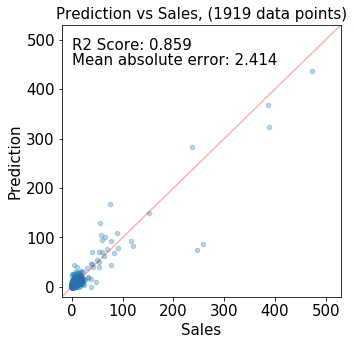

In [25]:
test.loc[:, 'Prediction'] = np.round(val)
test.plot.scatter(x='Sales', y='Prediction', figsize=(5,5), alpha=0.3, fontsize=15)
plt.xlim(-20,530)
plt.ylim(-20,530)
plt.text(1, 480, "R2 Score: %.3f" % np.mean(r2s), size=15)
plt.text(1, 450, "Mean absolute error: %.3f" % np.mean(mean_absolute_error), size=15)
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Sales',fontsize=15)
plt.title('Prediction vs Sales, (%i data points)' % len(test), fontsize=15)
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

We used last month data as baseline model for evaluating our regressor models. The R2 values of forecasting of the baseline model is already fairly high for both August and September. This means that the sales is consistent throughout the last few months.

## Use Random Forest Regressor For Forecasting

Month 31 - Absolute Error 2.422 	 R2 0.86
Month 32 - Absolute Error 1.973 	 R2 0.93
Mean Absolute Error = 2.198
Mean R2 Score = 0.891


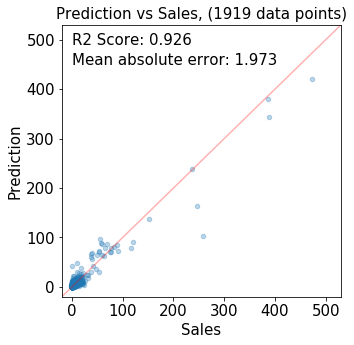

CPU times: user 2min 32s, sys: 1.49 s, total: 2min 33s
Wall time: 40.8 s


In [42]:
%%time
evaluate_RF(melt2)

Month 31 - Absolute Error 2.677 	 R2 0.74
Month 32 - Absolute Error 2.064 	 R2 0.92
Mean Absolute Error = 2.371
Mean R2 Score = 0.828


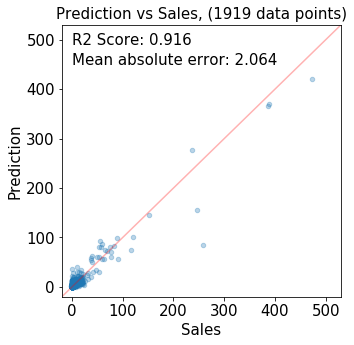

CPU times: user 3min 33s, sys: 2.07 s, total: 3min 35s
Wall time: 58.8 s


In [43]:
%%time
evaluate_RF(melt3)

Month 31 - Absolute Error 2.616 	 R2 0.80
Month 32 - Absolute Error 2.158 	 R2 0.90
Mean Absolute Error = 2.387
Mean R2 Score = 0.853


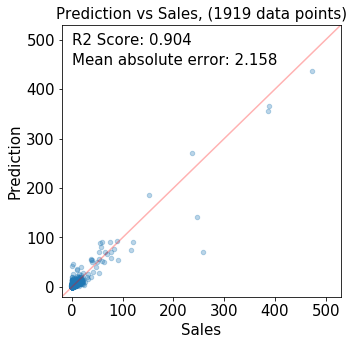

CPU times: user 4min 40s, sys: 3.05 s, total: 4min 43s
Wall time: 1min 31s


In [44]:
%%time
evaluate_RF(melt4)

The random forest models show some improvement from the baseline model by single digits in R2 value. Basic feature engineering helped optimize forecasting up to a point. In this case, the performance peaked at the first lag and difference of last month's data. The best model that yields the highest R2 score is using sales data of either two previous months.

Next, we will optimize the model by choosing the most efficient number of estimator.

In [29]:
%%time
train = melt2[melt2['Month'] < 32]
test = melt2[melt2['Month'] == 32]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

R2Score = []
CompTime = []

for trees in [10, 20, 50, 100, 200, 400, 600, 800, 1000]:
    t0 = time.process_time()
    RFR_time = RandomForestRegressor(n_estimators=trees, n_jobs=-1, random_state=0)
    RFR_time.fit(xtr, ytr)
    p = RFR_time.predict(xts)

    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    R2Score.append(error_r2)
    print(trees)
    print("Elapsed time: %.3f, error: %.3f" %(time.process_time() - t0, error_r2))
    CompTime.append((time.process_time() - t0)/60)

10
Elapsed time: 3.861, error: 0.907
20
Elapsed time: 8.699, error: 0.910
50
Elapsed time: 20.256, error: 0.919
100
Elapsed time: 40.236, error: 0.924
200
Elapsed time: 82.401, error: 0.926
400
Elapsed time: 162.824, error: 0.927
600
Elapsed time: 236.719, error: 0.925
800
Elapsed time: 319.950, error: 0.924
1000
Elapsed time: 394.683, error: 0.925
CPU times: user 20min 56s, sys: 13.2 s, total: 21min 9s
Wall time: 5min 49s


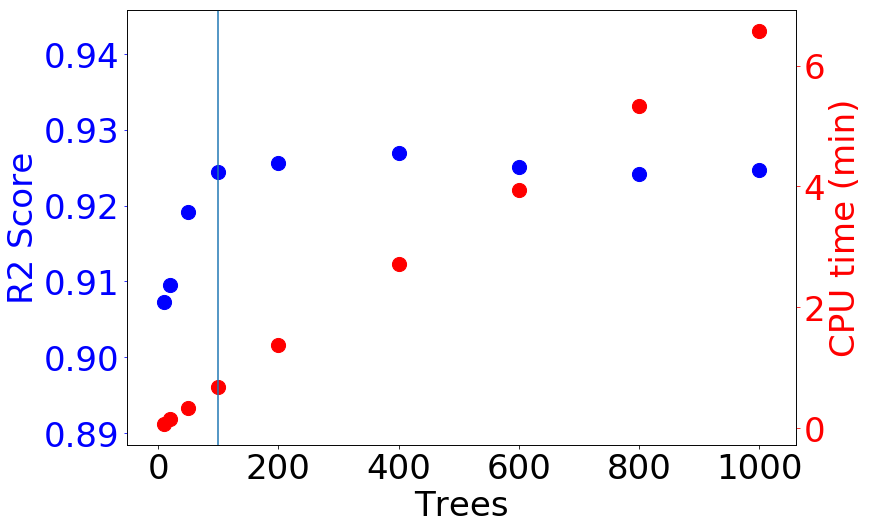

In [30]:
from collections import OrderedDict
df_rf = pd.DataFrame(OrderedDict({"Trees": [10, 20, 50, 100, 200, 400, 600, 800, 1000],
                     "R2 Score": R2Score, "CPU Time": CompTime}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_rf.Trees, df_rf["R2 Score"], color='b', s=200)
ax1.set_ylabel("R2 Score", size=34, color='b')
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', colors='b', labelsize=34)

ax2 = ax1.twinx()
ax2.scatter(df_rf.Trees, df_rf["CPU Time"], color='r', s=200)
ax2.set_ylabel("CPU time (min)", size=34, color='r')
ax2.tick_params('y', colors='r', labelsize = 34)

plt.axvline(100)

The chart above shows R2 value plateaued at 100 trees. We will go ahead and use 100 trees for the model.

Next, let's optimize the model by looking at feature importances.

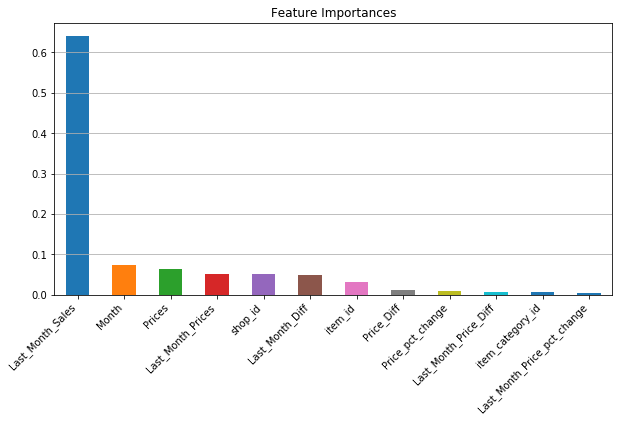

In [31]:
train = melt2[melt2['Month'] < 32]
test = melt2[melt2['Month'] == 32]
xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values
mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
mdl.fit(xtr, ytr)

predictors = [x for x in melt2.columns if x not in 'Sales']
plt.subplots(figsize=(10,5))
coef = pd.Series(mdl.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')
plt.xticks(rotation=45,horizontalalignment='right')
plt.grid(True, axis='y')

In [32]:
pd.options.display.float_format = '{:.4f}'.format
print(coef)

Last_Month_Sales              0.6413
Month                         0.0740
Prices                        0.0630
Last_Month_Prices             0.0520
shop_id                       0.0519
Last_Month_Diff               0.0488
item_id                       0.0302
Price_Diff                    0.0104
Price_pct_change              0.0099
Last_Month_Price_Diff         0.0071
item_category_id              0.0065
Last_Month_Price_pct_change   0.0049
dtype: float64


Interestingly, the feature of last month's sale is the only feature that has significant importance. And all other features are below 0.1. This makes sense because the baseline model that uses last month's sale record has R2 value of 0.84 on predicting September's sales.

Since the model has only 12 features, there are not much room for improving calculation by removing features. Now saving model for model comparison.

In [33]:
pickle.dump(mdl, open('RFR_final.pkl','wb'))

## Use Gradient Boosting For Forecasting

Month 31 - Absolute Error 3.035 	 R2 0.86
Month 32 - Absolute Error 2.500 	 R2 0.90
Mean Absolute Error = 2.768
Mean R2 Score = 0.878


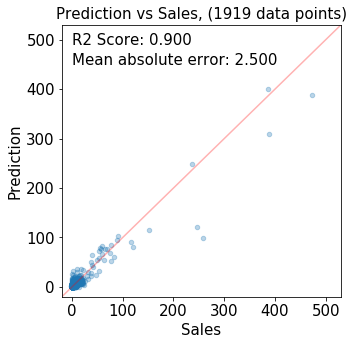

CPU times: user 23.6 s, sys: 183 ms, total: 23.8 s
Wall time: 23.9 s


In [34]:
%%time
evaluate_GB(melt2)

Month 31 - Absolute Error 3.621 	 R2 0.60
Month 32 - Absolute Error 2.656 	 R2 0.91
Mean Absolute Error = 3.139
Mean R2 Score = 0.751


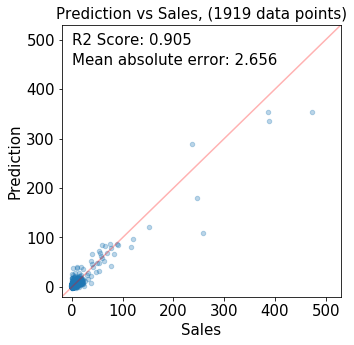

CPU times: user 29.6 s, sys: 220 ms, total: 29.8 s
Wall time: 29.9 s


In [35]:
%%time
evaluate_GB(melt3)

Month 31 - Absolute Error 3.548 	 R2 0.78
Month 32 - Absolute Error 2.637 	 R2 0.93
Mean Absolute Error = 3.092
Mean R2 Score = 0.854


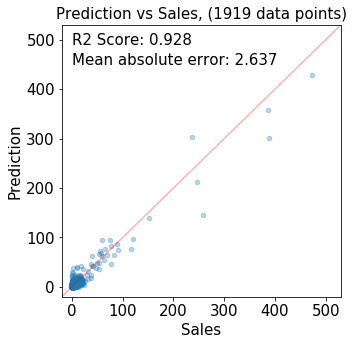

CPU times: user 37.9 s, sys: 311 ms, total: 38.2 s
Wall time: 38.5 s


In [36]:
%%time
evaluate_GB(melt4)

The training time of gradient boosting is much quicker compared to random forest. And the performance of gradient boosting model is highest at first lag of monthly data. The performance between the two regressors are similar. We will also optimize gradient boosting model and compare their performances with hold out set.

### Tuning Gradient Boosting estimators

In [37]:
%%time
train = melt2[melt2['Month'] < 32]
test = melt2[melt2['Month'] == 32]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

R2Score_GBR = []
CompTime_GBR = []

for trees in [10, 20, 50, 100, 200, 400, 600, 800, 1000]:
    t0 = time.process_time()
    GBR_time = GradientBoostingRegressor(n_estimators=trees, random_state=0)
    GBR_time.fit(xtr, ytr)
    p = GBR_time.predict(xts)

    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    R2Score_GBR.append(error_r2)
    print(trees)
    print("Elapsed time: %.3f, error: %.3f" %(time.process_time() - t0, error_r2))
    CompTime_GBR.append((time.process_time() - t0)/60)

10
Elapsed time: 0.261, error: 0.718
20
Elapsed time: 0.434, error: 0.817
50
Elapsed time: 1.072, error: 0.841
100
Elapsed time: 2.178, error: 0.863
200
Elapsed time: 5.278, error: 0.897
400
Elapsed time: 12.176, error: 0.902
600
Elapsed time: 13.718, error: 0.900
800
Elapsed time: 16.958, error: 0.905
1000
Elapsed time: 21.013, error: 0.905
CPU times: user 1min 12s, sys: 325 ms, total: 1min 13s
Wall time: 1min 13s


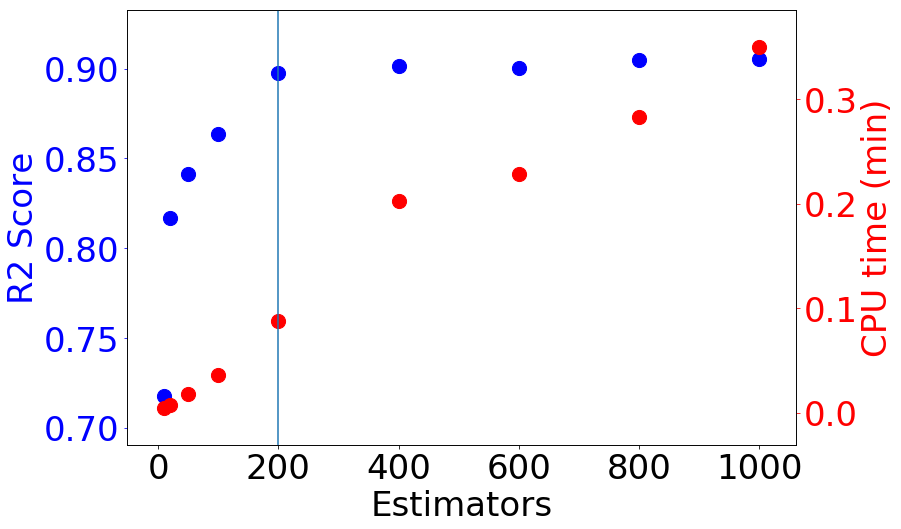

In [38]:
from collections import OrderedDict
df_gb = pd.DataFrame(OrderedDict({"Estimators": [10, 20, 50, 100, 200, 400, 600, 800, 1000],
                     "R2 Score": R2Score_GBR, "CPU Time": CompTime_GBR}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_gb.Estimators, df_gb["R2 Score"], color='b', s=200)
ax1.set_ylabel("R2 Score", size=34, color='b')
plt.xticks(fontsize=34)
plt.xlabel("Estimators", size=34)
ax1.tick_params('y', colors='b', labelsize=34)

ax2 = ax1.twinx()
ax2.scatter(df_gb.Estimators, df_gb["CPU Time"], color='r', s=200)
ax2.set_ylabel("CPU time (min)", size=34, color='r')
ax2.tick_params('y', colors='r', labelsize = 34)

plt.axvline(200)

The performance seems to plateau when estimator reaches 200 or above. We will use 200 estimators to compare with other models.

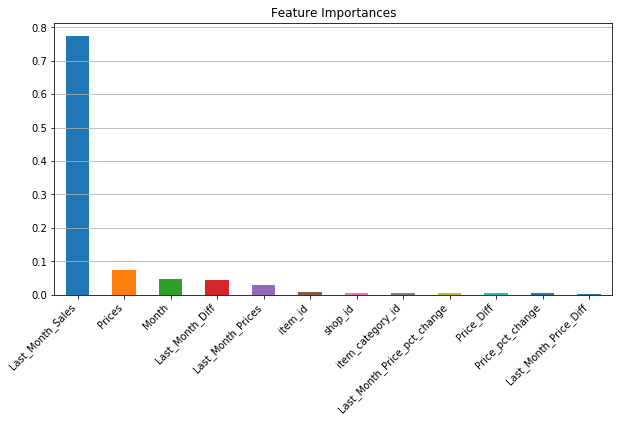

In [39]:
train = melt2[melt2['Month'] < 32]
test = melt2[melt2['Month'] == 32]
xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values
mdl = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=0)
mdl.fit(xtr, ytr)

predictors_GB = [x for x in melt2.columns if x not in 'Sales']
plt.subplots(figsize=(10,5))
coef = pd.Series(mdl.feature_importances_, predictors_GB).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')
plt.xticks(rotation=45,horizontalalignment='right')
plt.grid(True, axis='y')

In [40]:
print(coef)

Last_Month_Sales              0.7744
Prices                        0.0737
Month                         0.0464
Last_Month_Diff               0.0440
Last_Month_Prices             0.0300
item_id                       0.0070
shop_id                       0.0064
item_category_id              0.0046
Last_Month_Price_pct_change   0.0044
Price_Diff                    0.0036
Price_pct_change              0.0035
Last_Month_Price_Diff         0.0022
dtype: float64


Similarly to random forest regressor, sale of last month is weighted much more than the rest of features. Again, there is not much room for improvement with feature selection. Now saving model for model comparison.

In [41]:
pickle.dump(mdl, open('GBR_final.pkl','wb'))